# Basic Neural Net from scratch
## along fast.ai tutorial

https://www.kaggle.com/code/jhoward/linear-model-and-neural-net-from-scratch

## import data

In [1]:
import pandas as pd

import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    df = pd.read_csv("nnbasic-btc-data.csv", index_col=0).reset_index(drop=True)
else:
    df = pd.read_csv("nnbasic-btc-data.csv", index_col=0).reset_index(drop=True)


print(df.shape)
df.head(3)

(11713, 24)


,time_s3,open_s3,high_s3,low_s3,close_s3,vol_s3,time_s2,open_s2,high_s2,low_s2,...,high_s1,low_s1,close_s1,vol_s1,time,open,high,low,close,vol
0,2023.06.01 00:00,27103.1,27108.1,27080.6,27096.9,386.675,2023.06.01 00:15,27096.9,27096.9,27036.7,...,27077.4,27041.0,27054.9,275.080,2023.06.01 00:45,27054.9,27084.0,27054.8,27084.0,218.143
1,2023.06.01 00:15,27096.9,27096.9,27036.7,27047.0,408.680,2023.06.01 00:30,27047.0,27077.4,27041.0,...,27084.0,27054.8,27084.0,218.143,2023.06.01 01:00,27084.0,27113.9,27073.5,27100.0,329.412
2,2023.06.01 00:30,27047.0,27077.4,27041.0,27054.9,275.080,2023.06.01 00:45,27054.9,27084.0,27054.8,...,27113.9,27073.5,27100.0,329.412,2023.06.01 01:15,27100.0,27159.0,27100.0,27142.4,979.655


In [3]:
# do not use the time columns 

df_train = df.filter(items = ['open_s3', 'high_s3', 'low_s3', 'close_s3', 'vol_s3',
       'open_s2', 'high_s2', 'low_s2', 'close_s2', 'vol_s2',
       'open_s1', 'high_s1', 'low_s1', 'close_s1', 'vol_s1', 
       'open', 'high', 'low', 'close', 'vol']).dropna()
print(df_train.shape)
df_train.head(3)

(11713, 20)


,open_s3,high_s3,low_s3,close_s3,vol_s3,open_s2,high_s2,low_s2,close_s2,vol_s2,open_s1,high_s1,low_s1,close_s1,vol_s1,open,high,low,close,vol
0,27103.1,27108.1,27080.6,27096.9,386.675,27096.9,27096.9,27036.7,27047.0,408.680,27047.0,27077.4,27041.0,27054.9,275.080,27054.9,27084.0,27054.8,27084.0,218.143
1,27096.9,27096.9,27036.7,27047.0,408.680,27047.0,27077.4,27041.0,27054.9,275.080,27054.9,27084.0,27054.8,27084.0,218.143,27084.0,27113.9,27073.5,27100.0,329.412
2,27047.0,27077.4,27041.0,27054.9,275.080,27054.9,27084.0,27054.8,27084.0,218.143,27084.0,27113.9,27073.5,27100.0,329.412,27100.0,27159.0,27100.0,27142.4,979.655


### hist plots to check log normalization

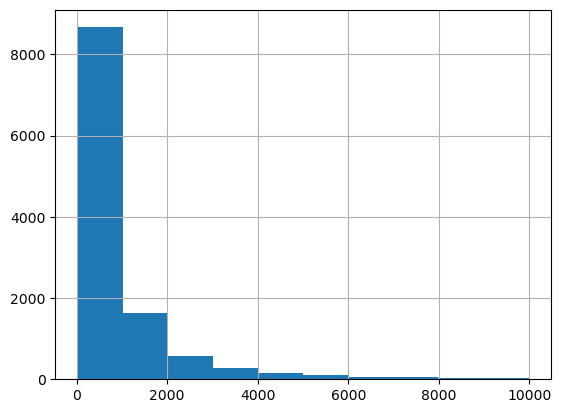

In [6]:
df_train['vol'].where(df_train.vol < 10000).hist();

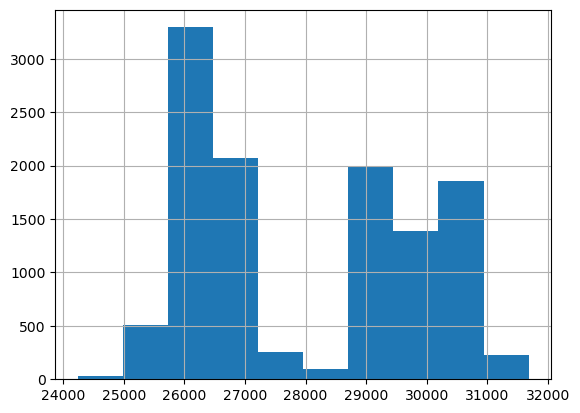

In [7]:
df_train['open'].hist();

### next

## dep, indep, weights and bias

In this setting we will just try to predict the high value based on the previous three candles. The results will likely not be good since point predictions are tricky.

In [ ]:
t_dep = tensor(df_train['high'].values, dtype=torch.float)
print(t_dep.shape) # 1 D tensor
t_dep

All variables are used instead of the high value which is the dependend value.

In [ ]:
t_indep = tensor(df_train.loc[:, df_train.columns != "high"].values, dtype=torch.float)

t_indep.shape # 2 D tensor > rows with observations and columns with features

The number of features needs to be the same as the lenght of the weights, because they will be multiplicated.

In [ ]:
import math

n,c = t_indep.shape

# "We are initializing the weights here with Xavier initialisation (by multiplying with 1/sqrt(n))."
weights = torch.randn(c) / math.sqrt(n)
weights.requires_grad_()
bias = torch.zeros(n, requires_grad=True)
weights.shape

In [ ]:
t_indep*weights

## making the first prediction

Since we are making a linear classifier the formula for yhat or the predictions is the sum of the products of coefficients and observations. 

In other words: 

$ y = x_0 \times b_0 + x_1 \times b_1 $

where $x_0$ is the first vector of observations (=features) and $b_0$ is the first coefficient.

and then is $y$ the vector with the predictions the same length as the data frame, so this formula can be read "rowwise".

In [ ]:
preds = (t_indep*coeffs).sum(axis=1)
print(preds.shape) # 1d vector of predictions
preds[0]

In [ ]:
# quick check for first row: 

print(t_indep[0])
print(coeffs)
print("\n first entry of Indep * coeffs: \n",t_indep[0][0]*coeffs[0])
print("\n Indep * coeffs: \n",t_indep[0]*coeffs)
print("\n sum of Indep * coeffs: \n", (t_indep[0]*coeffs).sum() ) #axis=1 is along the colums


## loss: cross entropy 

In [ ]:
import torch.nn.functional as F
loss_ce = F.cross_entropy(preds, t_dep)
loss_mae = F.l1_loss(preds, t_dep)
loss_mae = F.mse_loss(preds, t_dep)

print("mean absolute error:",loss_mae)
print("mean squared error:",loss_mae)
print("cross entropy:",loss_ce)

## gradients & learning rate

In [ ]:
coeffs

In [ ]:
coeffs.requires_grad_()

In [ ]:
# I am not sure if the above way works if I only use the loss functions in a functional style
# therefore, I document a way to use it instantiated as a class

from torch import nn

cel = nn.CrossEntropyLoss()

preds = (t_indep*coeffs.requires_grad_()).sum(axis=1)

loss = cel(preds,t_dep)
print(loss)
loss.backward(retain_graph=True)

gradients = coeffs.grad
print(gradients)

In [ ]:
loss.backward(retain_graph=True)
print(coeffs.grad)

In [ ]:
# initialise coeffs and define the independent variable 
t_indep*coeffs

# define it as a function 
def calc_preds(coeffs, indeps): return (indeps*coeffs).sum(axis=1)
    
preds = (t_indep*coeffs).sum(axis=1)

In [ ]:
# define the loss function

# herer it is mean absolute error
loss = torch.abs(preds-t_dep).mean()

# define it in a function
def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps)-deps).mean()

## next steps

 - figure out when and how to use backward() and require_grad
 - put the pieces togehter: calc preds > calc loss > get gradients > subtract gradients*learningrate with preds

Note on gradients: \n
My current understand is that you need to specify the tensor of where to calculate the gradients on, to access them explicitly. \n
It seems, that the backward function needs to know the input, target and weights.